<a href="https://colab.research.google.com/github/allnes/age_classifier/blob/master/train_age_9_class_230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to Google Drive

In [1]:
%tensorflow_version 1.x

from google.colab import drive
import os, natsort as nsrt, numpy as np, re
from scipy.sparse import coo_matrix, csgraph, csr_matrix
import matplotlib.pyplot as plt
import cv2 as cv
import scipy
!pip install -U scikit-learn
import sklearn

drive.mount('/content/drive')
PATH_PROJECT='/content/drive/My Drive/DL_DATA_GRAPH/'
PATH_CNN_REPO=PATH_PROJECT + 'BUILD/cnn_graph/'
os.chdir(PATH_CNN_REPO)
from lib import models, graph, coarsening, utils
%ls

# !git clone https://github.com/mdeff/cnn_graph
!git pull origin master

os.chdir(PATH_PROJECT)
%ls
%matplotlib inline

TensorFlow 1.x selected.
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
checkpoints/  makefile    README.md         trials/
lib/          nips2016/   requirements.txt  usage.ipynb
LICENSE.txt   rcv1.ipynb  summaries/
From https://github.com/allnes/cnn_graph
 * branch            master     -> FETCH_HEAD
Already up to date.
BUILD/  DATA/


## Preprocessing data

['arr_0', 'arr_1']
(729, 52900)
(729,)
--> Reshape data
[0 1 2 3 4 5 6 7 8]
d = |V| = 230, k|V| < |E| = 414528


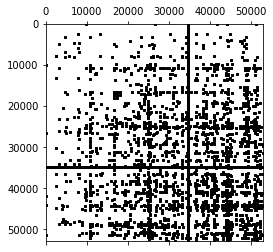

In [2]:
PATH_GRAPHS=PATH_PROJECT + 'DATA/mini_graphs/graphs/'
list_grpahs = []
for (_, _, filenames) in os.walk(PATH_GRAPHS):
    list_grpahs = list_grpahs + filenames

list_grpahs = nsrt.natsorted(list_grpahs)[0::2]

num_samples = int(np.load(PATH_GRAPHS + list_grpahs[0])['num_samples'])
num_features = int(np.load(PATH_GRAPHS + list_grpahs[0])['num_features'])

def save_zip(save_size):
    list_of_rows = []
    list_of_cols = []
    list_of_max_vertices = []
    list_of_data = []

    zip_size = save_size

    for graph_name in list_grpahs:
        with np.load(PATH_GRAPHS + graph_name) as raw_graph:
            raw_edges = raw_graph['E'].transpose()
            rows = np.array(raw_edges[0])
            cols = np.array(raw_edges[1])

            max_range = max(np.max(rows), np.max(cols))
            unused_indexes = []
            for index in range(max_range):
                if (not index in rows) and (not index in cols):
                    unused_indexes.append(index)
            unused_indexes = np.array(unused_indexes)

            used_indexes = np.concatenate((rows, cols))
            used_indexes = np.unique(used_indexes, axis=0)
            used_indexes[::-1].sort()

            for used_var, unused_var in zip(used_indexes, unused_indexes):
                np.place(rows, rows == used_var, unused_var)
                np.place(cols, cols == used_var, unused_var)
            max_range = max(np.max(rows), np.max(cols))
            raw_data = raw_graph['D']

            list_of_rows.append(rows)
            list_of_cols.append(cols)
            list_of_max_vertices.append(max_range)
            list_of_data.append(raw_data)

            # print('used vertices shape: ', used_indexes.shape)
            # print('unused vertices shape:', unused_indexes.shape)
            # print('new max of vertices: ', max_range)

    assert np.max(list_of_max_vertices) == np.min(list_of_max_vertices)
    size_matrix = np.max(list_of_max_vertices) + 1

    X = []
    for raw_data, rows, cols in zip(list_of_data, list_of_rows, list_of_cols):
        sparse_graph = coo_matrix((raw_data, (rows, cols)),
                                  shape=(size_matrix, size_matrix))
        dense_graph = sparse_graph.todense()
        X.append(cv.resize(dense_graph, 
                           dsize=(zip_size, zip_size), 
                           interpolation=cv.INTER_CUBIC))
    X = np.array(X)
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

    PATH_LABELS=PATH_PROJECT + 'DATA/mini_graphs/GSE87571_samples.txt'

    raw_file = open(PATH_LABELS, 'r')
    y = []
    for line in raw_file.readlines():
        match_obj = re.match(r'(GSM[0-9]*)\s*([M,F])\s*([0-9]*)\s*([0-9]*)', line)
        if not match_obj is None: 
            y.append(int(match_obj.group(3)))
    y = np.array(y)

    assert len(y) == num_samples
    assert len(X) == num_samples

    print(raw_graph.files)
    print(X.shape)
    print(y.shape)

    # outfile = PATH_PROJECT + 'DATA/converted_data.npz'
    outfile = PATH_PROJECT + 'DATA/converted_data_resize_' + str(zip_size) + '.npz'
    np.savez(outfile, X, y)

zip_size = 230
# save_zip(zip_size)

PATH_CONVERTED_DATA = PATH_PROJECT + 'DATA/converted_data_resize_' + str(zip_size) + '.npz'
# PATH_CONVERTED_DATA = PATH_PROJECT + 'DATA/converted_data_resize_875_lam_192.npz'

npzfile = np.load(PATH_CONVERTED_DATA)
print(npzfile.files)
X = npzfile['arr_0'].astype(np.float32)
y = npzfile['arr_1']
print(X.shape)
print(y.shape)

##########################################################

print('--> Reshape data')
n_train = (num_samples * 3) // 4
n_val = num_samples // 10

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y = y // 10 - 1
# y = y // 25 
y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

print(np.unique(y))

##########################################################

# print('--> Get distance graph')
# def distance_sklearn_metrics(z, k=4, metric='euclidean'):
#     """Compute exact pairwise distances."""
#     d = sklearn.metrics.pairwise.pairwise_distances(
#             z, metric=metric, n_jobs=-2)
#     # k-NN graph.
#     idx = np.argsort(d)[:, 1:k+1]
#     d.sort()
#     d = d[:, 1:k+1]
#     return d, idx

  
# dist, idx = distance_sklearn_metrics(X_train.T)
# A = graph.adjacency(dist, idx).astype(np.float32)

# PATH_DUMP_DATA = PATH_PROJECT + 'DATA/dump.npz'
# scipy.sparse.save_npz(PATH_DUMP_DATA, A)

PATH_DUMP_LOAD_DATA = PATH_PROJECT + 'DATA/dump.npz'
A = scipy.sparse.load_npz(PATH_DUMP_LOAD_DATA)


print('d = |V| = {}, k|V| < |E| = {}'.format(zip_size, A.nnz))
plt.spy(A, markersize=2, color='black');

## Train

In [3]:
print('--> Get laplacian matrix')
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=True)
X_train = coarsening.perm_data(X_train, perm)
print(X_train.shape)
X_val = coarsening.perm_data(X_val, perm)
print(X_val.shape)
X_test = coarsening.perm_data(X_test, perm)
print(X_test.shape)

--> Get laplacian matrix


/content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])
/content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])
/content/drive/My Drive/DL_DATA_GRAPH/BUILD/cnn_graph/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])


Layer 0: M_0 = |V| = 412152 nodes (359252 added),|E| = 207264 edges
Layer 1: M_1 = |V| = 206076 nodes (153561 added),|E| = 207230 edges
Layer 2: M_2 = |V| = 103038 nodes (50999 added),|E| = 205872 edges
Layer 3: M_3 = |V| = 51519 nodes (0 added),|E| = 204456 edges
(546, 412152)
(72, 412152)
(111, 412152)


In [0]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

In [0]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 32
params['batch_size']     = 16
params['eval_frequency'] = 100

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['brelu']          = 'b2relu'
params['pool']           = 'apool1'
params['pool']           = 'mpool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 32]  # Number of graph convolutional filters.
params['K']              = [16, 16]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [1000, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0
params['decay_steps']    = n_train / params['batch_size']

In [6]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 412152
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 412152 * 32 / 4 = 3297216
    weights: F_0 * F_1 * K_1 = 1 * 32 * 16 = 512
    biases: M_1 * F_1 = 412152 * 32 = 13188864
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 103038 * 32 / 2 = 1648608
    weights: F_1 * F_2 * K_2 = 32 * 32 * 16 = 16384
    biases: M_2 * F_2 = 103038 * 32 = 3297216
  layer 3: fc1
    representation: M_3 = 1000
    weights: M_2 * M_3 = 1648608 * 1000 = 1648608000
    biases: M_3 = 1000
  layer 4: logits (softmax)
    representation: M_4 = 9
    weights: M_3 * M_4 = 1000 * 9 = 9000
    biases: M_4 = 9







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.








step 100 / 1092 (epoch 2.93 / 32):
  learning_rate = 9.03e-04, loss_average = 3.19e+03
  validation accuracy: 22.22 (16 / 72), f1 (weighted): 13.02, loss: 3.54e+03
  time: 15649s (wal

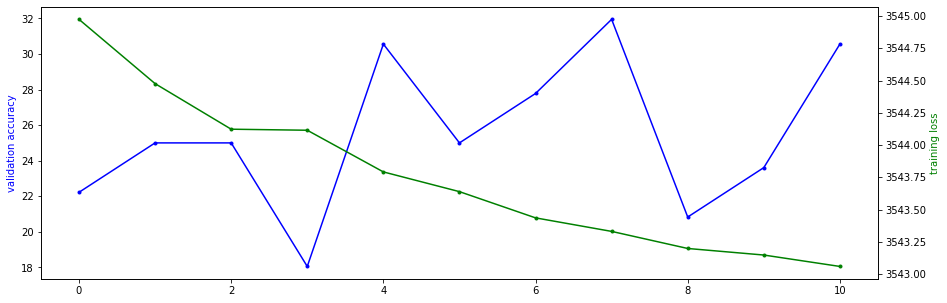

In [7]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [8]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 11776.48 ms


In [13]:
res = model.evaluate(X_test, y_test)
print(res[0])

accuracy: 24.32 (27 / 111), f1 (weighted): 20.58, loss: 3.22e+03
time: 340s (wall 464s)
